In [1]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp
from sklearn.model_selection import StratifiedKFold
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as albu
from PIL import Image

In [2]:
DATA_DIR = '/mnt/chicm/data/bengali'
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [3]:
df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet')
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [4]:
HEIGHT = 137
WIDTH = 236

def get_img(img_idx):
    return 255 - df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)

In [5]:
def get_img_tensor(img_idx):
    img = get_img(img_idx)
    return transforms.functional.to_tensor(img)

In [6]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    plt.figure(figsize=(30, 20))
    columns = 4
    for i, img in enumerate(imgs):
        plt.subplot(n / columns + 1, columns, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

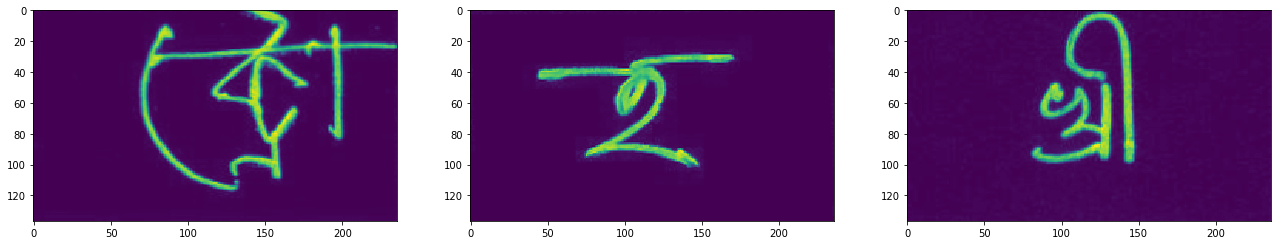

In [7]:
show_imgs([get_img(0), get_img(1), get_img(2)])

In [8]:
x = get_img_tensor(0)

In [9]:
x.size()

torch.Size([1, 137, 236])

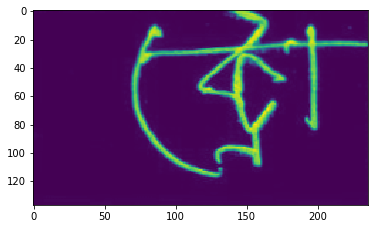

In [10]:
plt.imshow(transforms.functional.to_pil_image(x))

In [11]:
def get_train_augs(p=1.):
    return albu.Compose([
        #albu.HorizontalFlip(.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5 ),
        albu.Blur(blur_limit=3, p=0.3),
        albu.OpticalDistortion(p=0.3),
        albu.GaussNoise(p=0.3),
        albu.GridDistortion(p=1.),
        #albu.HueSaturationValue(p=.33) # not for grey scale
    ], p=p)
augs = get_train_augs()

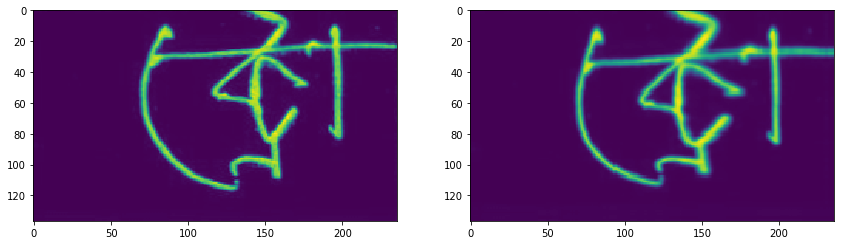

In [12]:
img = get_img(0)
img_aug = augs(image=img)['image']
show_imgs([img, img_aug])

# cvcore

In [13]:
!pip show cvcore

Name: cvcore
Version: 0.0.1
Summary: Computer Vision Pytorch-based Toolbox
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /mnt/chicm/bengaliai-cv19
Requires: albumentations, torch, torchvision, timm
Required-by: 


In [14]:
!ls /mnt/chicm/bengaliai-cv19/cvcore/data

auto_augment.py       cutmix_mixup.py  __pycache__
bengaliai_dataset.py  __init__.py


In [15]:
from cvcore.data.auto_augment import Invert, RandAugment, AugmentAndMix

In [16]:
aug = RandAugment(n=2, m=27)

In [25]:
img_aug = aug(Image.fromarray(img))

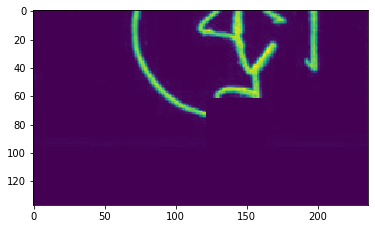

In [26]:
plt.imshow(img_aug)

In [29]:
np.asarray(img_aug).mean()

9.343653346529754

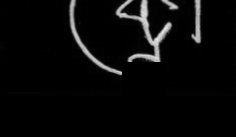

In [28]:
np(img_aug

# cyclic lr scheduler

In [71]:
from cvcore.solver import WarmupCyclicalLR
import torch.nn.functional as F
from tqdm import tqdm

In [53]:
def make_optimizer(model, base_lr=4e-4, weight_decay=0., weight_decay_bias=0., epsilon=1e-3):
    """
    Create optimizer with per-layer learning rate and weight decay.
    """
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        lr = base_lr
        params += [{"params": [value], "lr": lr, "weight_decay": weight_decay_bias if 'bias' in key else weight_decay}]
    
    optimizer = torch.optim.AdamW(params, lr, eps=epsilon)
    return optimizer

In [63]:
def get_lrs(optimizer):
    lrs = []
    for pgs in optimizer.state_dict()['param_groups']:
        lrs.append(pgs['lr'])
    lrs = ['{:.6f}'.format(x) for x in lrs]
    return lrs

In [66]:
model = EfficientNet.from_pretrained('efficientnet-b0').cuda()

Loaded pretrained weights for efficientnet-b0


In [50]:
model(torch.randn(2,3,224,224).cuda()).size()

torch.Size([2, 1000])

In [91]:
optimizer = make_optimizer(model)
scheduler = WarmupCyclicalLR("cos", 4e-4, 100, iters_per_epoch=20, warmup_epochs=10)

In [99]:
lr_hist = []
for epoch in tqdm(range(100)):
    for i in range(20):
        output = model(torch.randn(2,3,224,224).cuda())
        y = torch.tensor([1,2]).cuda()
        loss = F.cross_entropy(output, y)
        scheduler(optimizer, i, epoch)
        optimizer.step()
        optimizer.zero_grad()
        lr_hist.append(float(get_lrs(optimizer)[0])*1000)

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


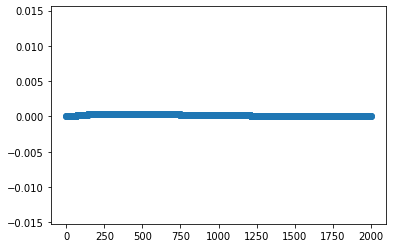

In [93]:
plt.scatter(list(range(len(lr_hist))), lr_hist)

In [94]:
len(lr_hist)

2000

In [97]:
lr_hist[:200]

[0.0,
 2e-06,
 4e-06,
 6e-06,
 8e-06,
 1e-05,
 1.2e-05,
 1.4e-05,
 1.6e-05,
 1.8e-05,
 2e-05,
 2.2e-05,
 2.4e-05,
 2.6e-05,
 2.8e-05,
 3e-05,
 3.2e-05,
 3.4e-05,
 3.6e-05,
 3.8e-05,
 4e-05,
 4.2e-05,
 4.4e-05,
 4.6e-05,
 4.8e-05,
 5e-05,
 5.2e-05,
 5.4e-05,
 5.6e-05,
 5.8e-05,
 6e-05,
 6.2e-05,
 6.4e-05,
 6.6e-05,
 6.8e-05,
 7e-05,
 7.2e-05,
 7.4e-05,
 7.6e-05,
 7.8e-05,
 8e-05,
 8.2e-05,
 8.4e-05,
 8.6e-05,
 8.8e-05,
 9e-05,
 9.2e-05,
 9.4e-05,
 9.6e-05,
 9.8e-05,
 0.0001,
 0.000102,
 0.000104,
 0.000106,
 0.000108,
 0.00011,
 0.000112,
 0.000114,
 0.000116,
 0.000118,
 0.00012,
 0.000122,
 0.000124,
 0.000126,
 0.000128,
 0.00013,
 0.000132,
 0.000134,
 0.000136,
 0.000138,
 0.00014,
 0.000142,
 0.000144,
 0.000146,
 0.000148,
 0.000149,
 0.000151,
 0.000153,
 0.000155,
 0.000157,
 0.000159,
 0.000161,
 0.000163,
 0.000165,
 0.000167,
 0.000169,
 0.000171,
 0.000173,
 0.000175,
 0.000177,
 0.000179,
 0.000181,
 0.000183,
 0.000185,
 0.000187,
 0.000189,
 0.000191,
 0.000193,
 0.00019